In [1]:
from collections import Counter
from itertools import combinations
import random
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Setting random seeds to replicate results easily
random.seed(0)
np.random.seed(0)
tensorflow.random.set_seed(0)

# Root Mean Squared Error (RMSE)
In this tutorial, RMSE is used to evaluate the performance of a model. A model that reports lower RMSE indicates that it is a better model and vice versa.

In [2]:
def rmse(pred, actual):
    '''
    params:
        pred <np.array>: an array containing all predicted ratings
        actual <np.array>: an array containing all ground truth ratings

    return:
        a scalar whose value is the rmse
    '''
    # Ignore ratings with value zero.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

# Wide and Deep Learning (WDL) Model Implementation
The Wide and Deep Learning Model can be divided into two parts, the "wide" part and the "deep" part.

**The wide component** is a generalized linear model that takes in the raw input features and the cross-product transformation of categorical features, which enables it to **learn the co-occurrence patterns of items or features**.

**The deep component** is a Feed-forward Neural Network (FNN) which takes in both continuous and categorical features as input. Specifically, the normalized values of continuous features are concatenated with the low-dimensional dense embedding vectors converted from categorical features. This concatenated vector is then fed into the FNN during each foward pass. This mechanism tends to **increase the diversity of recommendations**.

In [3]:
def build_wdl_model(len_continuous, deep_vocab_lens, len_wide, embed_size, dropout_rate, deep_layers):  # added dropout_rate and deep_layers parameters by HCJ
    '''
    params:
        len_continuous: number of continuous features
        deep_vocab_lens: an array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
        len_wide: number of wide features
        embed_size: dimension of the embedding vectors of deep categorical features

    return:
        a keras Model object for the constructed wdl model 
    '''
    # A list containing all input layers
    input_list = []
    
    # Input layer for continuous features
    continuous_input = Input(shape=(len_continuous,), dtype='float32', name='continuous_input')
    input_list.append(continuous_input)

    # Get embeddings for all deep categorical features
    emb_list = []
    for vocab_size in deep_vocab_lens:
        _input = Input(shape=(1,), dtype='int32')
        input_list.append(_input)
        _emb = Embedding(output_dim=embed_size, input_dim=vocab_size, input_length=1)(_input)
        _emb = Reshape((embed_size,))(_emb)
        emb_list.append(_emb)

    # Create input layer for deep component by concatenating the embeddings and continuous features' input layer
    deep_input = Concatenate()(emb_list + [continuous_input])

    # Construct deep component - modified by HCJ
    for i in range(len(deep_layers)):
        dense_i = Dense(deep_layers[i], activation='relu')(deep_input)
        dense_i_dp = Dropout(dropout_rate)(dense_i)
        deep_input = dense_i_dp
     
    #dense_1 = Dense(256, activation='relu')(deep_input)
    #dense_1_dp = Dropout(0.3)(dense_1)
    #dense_2 = Dense(128, activation='relu')(dense_1_dp)
    #dense_2_dp = Dropout(0.3)(dense_2)
    #dense_3 = Dense(64, activation='relu')(dense_2_dp)
    #dense_3_dp = Dropout(0.3)(dense_3)

    # Create input layer for wide component
    wide_input = Input(shape=(len_wide,), dtype='float32')
    input_list.append(wide_input)

    # Concatenate the outputs of deep and wide components and feed the concatenated vector into the finall fully connected layer
    #fc_input = Concatenate()([dense_3_dp, wide_input])  # OLD
    fc_input = Concatenate()([deep_input, wide_input])  # NEW - by HCJ
    model_output = Dense(1)(fc_input)

    model = Model(inputs=input_list, outputs=model_output)
    return model

# Data Preprocessing
Below are utility functions that helps us retrieve the numerical values of different features from the dataset, and generate combinations of features to be used by the WDL model.

### Retrieving Continuous Features

In [4]:
def get_continuous_features(df, continuous_columns):
    '''
    params:
        df: input dataframe
        continuous_columns: column names of continuous features

    return: 
        a numpy array where each row contains the values of continuous features in the corresponding row of the input dataframe
    '''
    continuous_features = df[continuous_columns].values
    return continuous_features

### Categorical Features Cross Product Transformation
This function is used to generate a variety of feature combinations that occurred frequently in the dataset.

For example, the following items occurred frequently in the dataset:

|Item Name|Occurrence|
|---|---|
|A|4|
|B|3|
|C|2|
|D|1|

If we set `topk=3`, it means that we will only consider the top 3 items with the highest occurrence to generate combinations.

If we set `comb_p=2`, it means that we will generate combinations with 2 items in each generated combinations.

In this case, the following combinations will be generated: `[('A', 'B'), ('A', 'C'), ('B', 'C')]`

Test code: `get_top_k_p_combinations(pd.DataFrame({'item_categories': ['A, B, C, D', 'A, B, C', 'A, B', 'A']}), comb_p=2, topk=3, output_freq=False)`

In [5]:
def get_top_k_p_combinations(df, comb_p, topk, output_freq=False):
    '''
    params:
        df: input dataframe
        comb_p: number of elements in each combination (e.g., there are two elements in the combination {fried chicken, chicken and waffle}, and three elements in the combination {fried chicken, chicken and waffle, chicken fried rice})
        topk: number of most frequent combinations to retrieve
        output_freq: whether to return the frequencies of retrieved combinations

    return:
        1. output_freq = True: a list X where each element is a tuple containing a combination tuple and corresponding frequency, and the elements are stored in the descending order of their frequencies
        2. output_freq = False: a list X where each element is a tuple containing a combination tuple, and the elements are stored in the descending order of their frequencies
    '''
    def get_category_combinations(categories_str, comb_p=2):
        categories = categories_str.split(', ')
        return list(combinations(categories, comb_p))
    all_categories_p_combos = df["item_categories"].apply(lambda x: get_category_combinations(x, comb_p)).values.tolist()
    all_categories_p_combos = [tuple(t) for item in all_categories_p_combos for t in item]
    tmp = dict(Counter(all_categories_p_combos))
    sorted_categories_combinations = list(sorted(tmp.items(), key=lambda x: x[1], reverse=True))
    if output_freq:
        return sorted_categories_combinations[:topk]
    else:
        return [t[0] for t in sorted_categories_combinations[:topk]]

### Building Wide Features

In [6]:
def get_wide_features(df, selected_categories_to_idx, top_combinations):
    '''
    params:
        df: input dataframe
        selected_categories_to_idx: a dictionary mapping item categories to corrresponding integral indices
        top_combinations: a list containing retrieved mostly frequent combinantions of item categories

    return:
        a numpy array where each row contains the categorical features' binary encodings and cross product transformations for the corresponding row of the input dataframe
    '''
    def categories_to_binary_output(categories):
        binary_output = [0 for _ in range(len(selected_categories_to_idx))]
        for category in categories.split(', '):
            if category in selected_categories_to_idx:
                binary_output[selected_categories_to_idx[category]] = 1
            else:
                binary_output[0] = 1
        return binary_output
    def categories_cross_transformation(categories):
        current_category_set = set(categories.split(', '))
        corss_transform_output = [0 for _ in range(len(top_combinations))]
        for k, comb_k in enumerate(top_combinations):
            if len(current_category_set & comb_k) == len(comb_k):
                corss_transform_output[k] = 1
            else:
                corss_transform_output[k] = 0
        return corss_transform_output

    category_binary_features = np.array(df.item_categories.apply(lambda x: categories_to_binary_output(x)).values.tolist())
    category_cross_transform_features = np.array(df.item_categories.apply(lambda x: categories_cross_transformation(x)).values.tolist())
    return np.concatenate((category_binary_features, category_cross_transform_features), axis=1)

# Ratings Prediction

### Loading train, validation and test rating tables

In [7]:
# TODO remove if not running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

# cd into appropriate directory on Google Drive
!rm -f data
%cd /content/drive/My Drive/4-2/COMP4332/Project3/data

# end TODO remove

# S1: Dropout=0, Dense1 layer had output of dimension 512 instead of 256.

tr_df = pd.read_csv("./train.csv")
val_df = pd.read_csv("./valid.csv")
te_df = pd.read_csv("./test.csv")

tr_ratings = tr_df['stars'].values
val_ratings = val_df['stars'].values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/4-2/COMP4332/Project3/data


### Loading content feautures tables of users and items

In [8]:
user_df = pd.read_csv("./user.csv", index_col=0)  # HCJ: changed filepath since on Google Colab
item_df = pd.read_csv("./business.csv", index_col=0)

# Renaming columns by adding prefixes to column names
user_df = user_df.rename(index=str, columns={t: 'user_' + t for t in user_df.columns if t != 'user_id'})
item_df = item_df.rename(index=str, columns={t: 'item_' + t for t in item_df.columns if t != 'business_id'})

### Expanding the table by using user_id and business_id
Expanding the train, valiation and test dataset by using `user_id` and `business_id` to query more features from `user_df` and `item_df`.

In [9]:
# feature engineering for items (aka businesses)
item_attributes = []

# helper lambda function to check if a given row of item dataframe has the given attribute name in the 'attributes' column of business.csv
def make_item_attr(attribute_name, attr):
    if isinstance(attr, str):
        attr = eval(attr)
        if attribute_name in attr:
            return attr[attribute_name]
    return 'unk'

# Specify column names of deep categorical features for items
# OLD
item_deep_columns = ["item_city", "item_postal_code", "item_state"]
# NEW: added by HCJ
item_deep_columns = ["item_city", "item_postal_code", "item_state",
                     'business_id', 'item_RestaurantsAttire', 'item_WiFi',
                     'item_Ambience', 'item_NoiseLevel', 'item_BusinessAcceptsCreditCards', 
                     'item_RestaurantsPriceRange2', 'item_GoodForMeal', 
                     'item_BusinessParking', 'item_RestaurantsGoodForGroups', 'item_Alcohol',
                     'item_RestaurantsReservations']
for i, attr in enumerate(item_deep_columns):
    if i >= 4:  # ignore the first 4 entries in item_deep_columns
        # attr[5:] changes something like 'item_Ambience' to 'Ambience'
        item_df[attr] = item_df.item_attributes.apply(lambda x: make_item_attr(attr[5:], x))


In [10]:
# HCJ: added sort_values of merged dataframe by index
tr_df["index"] = tr_df.index
val_df["index"]  = val_df.index
te_df["index"] = te_df.index

tr_df = pd.merge(pd.merge(tr_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)
val_df = pd.merge(pd.merge(val_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)
te_df = pd.merge(pd.merge(te_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)

### Preparing continuous features

In [11]:
# Specify the columns containing continuous features
# OLD
continuous_columns = ["user_average_stars", "user_cool", "user_fans", 
                      "user_review_count", "user_useful", "user_funny",
                      "item_is_open", "item_latitude", "item_longitude", 
                      "item_review_count", "item_stars"]
# NEW: added by HCJ
continuous_columns = ["user_average_stars", "user_cool", "user_fans", 
                      "user_review_count", "user_useful", "user_funny",
                      "item_is_open", "item_latitude", "item_longitude", 
                      "item_review_count", "item_stars",
                      'user_compliment_hot', 'user_compliment_more',
                      'user_compliment_profile', 'user_compliment_cute',
                      'user_compliment_list', 'user_compliment_note', 'user_compliment_plain',
                      'user_compliment_cool', 'user_compliment_funny',
                      'user_compliment_writer', 'user_compliment_photos',
                     ]

# Get values of continous features for train/validation/test sets using the utility function defined previously

tr_continuous_features = get_continuous_features(tr_df, continuous_columns)
val_continuous_features = get_continuous_features(val_df, continuous_columns)
te_continuous_features = get_continuous_features(te_df, continuous_columns)

# Standardize each feature by removing the mean of the training samples and scaling to unit variance.
# See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html for more details.
scaler = StandardScaler().fit(tr_continuous_features)

tr_continuous_features = scaler.transform(tr_continuous_features)
val_continuous_features = scaler.transform(val_continuous_features)
te_continuous_features = scaler.transform(te_continuous_features)

tr_continuous_features.shape

(60080, 22)

### Preparing deep categorical features

In [12]:
# An array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
# Transforming words into indices for each categorical columns
item_deep_vocab_lens = []
for col_name in item_deep_columns:
    # Getting unique values of this deep categorical feature
    unique_values = item_df[col_name].unique()
    
    # Creating a dictionary to map from unique values to the corresponding index
    vocab = dict(zip(unique_values, range(1, len(unique_values)+1)))
    
    # Getting the number of unique values of this deep categorical features
    item_deep_vocab_lens.append(len(vocab)+1)
    
    # Creating a new column where each entry stores the index of this deep categorical feature's value in the same row
    item_df[col_name + "_idx"] = item_df[col_name].apply(lambda x: vocab[x])


# Creating a dictionary mapping each business id to corresponding values of deep categorical features ('business_id' -> ['item_city_idx', 'item_postal_code_idx', 'item_state_idx'] in this case)
item_deep_idx_columns = [t + "_idx" for t in item_deep_columns]
item_to_deep_categorical_features = dict(zip(item_df['business_id'].values, item_df[item_deep_idx_columns].values.tolist()))

# Creating numpy arrays storing corresponding deep categorical features' values of train/validation/test sets using the above mapping
# OLD: removed by HCJ
# tr_deep_categorical_features = np.array(tr_df['business_id'].apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())
# val_deep_categorical_features = np.array(val_df['business_id'].apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())
# te_deep_categorical_features = np.array(te_df['business_id'].apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())

In [13]:
# this is basically a copy of the above cell but with categorical features for users.
# Specify column names of deep categorical features for users
user_deep_columns = ["user_id", "user_elite"]

# An array of integers where user_deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
user_deep_vocab_lens = []

# for each column in the set of user deep categorical features
for col_name in user_deep_columns:
    # Get all unique values of this deep categorical feature
    unique_values = user_df[col_name].unique()
    
    # Create a dictionary mapping each unique value of that deep categorical feature to a unique integer index
    vocab = dict(zip(unique_values, range(1, len(unique_values) + 1)))
    
    # Get the number of unique values of this deep categorical features and save to user_deep_vocab_lens
    user_deep_vocab_lens.append(len(vocab) + 1)
    
    # Create a new column where each entry stores the integer index of this deep categorical feature's value in the same row
    user_df[col_name + "_idx"] = user_df[col_name].apply(lambda x: vocab[x])

# Create a dictionary mapping each business id to corresponding values of deep categorical features
user_deep_idx_columns = [t + "_idx" for t in user_deep_columns]
user_to_deep_categorical_features = dict(zip(user_df["user_id"].values, user_df[user_deep_idx_columns].values.tolist()))

tr_deep_categorical_features = np.array(tr_df.apply(lambda row: item_to_deep_categorical_features[row.business_id] + user_to_deep_categorical_features[row.user_id], axis=1).values.tolist())
val_deep_categorical_features = np.array(val_df.apply(lambda row: item_to_deep_categorical_features[row.business_id] + user_to_deep_categorical_features[row.user_id], axis=1).values.tolist())
te_deep_categorical_features = np.array(te_df.apply(lambda row: item_to_deep_categorical_features[row.business_id] + user_to_deep_categorical_features[row.user_id], axis=1).values.tolist())

tr_deep_categorical_features.shape

(60080, 17)

### Preparing wide features

##### Preparing binary encoding for each selected category

In [14]:
# Collect the categories of all items 
all_categories = [category for category_list in item_df.item_categories.values for category in category_list.split(", ")]

# Sort all unique values of the item categories by their frequencies in descending order
category_sorted = sorted(Counter(all_categories).items(), key=lambda x: x[1], reverse=True)

# Select top 500 most frequent categories
selected_categories = [t[0] for t in category_sorted[:500]]

# Create a dictionary mapping each secleted category to a unique integral index
selected_categories_to_idx = dict(zip(selected_categories, range(1, len(selected_categories) + 1)))

# Map all categories unseen in the item df to index 0
selected_categories_to_idx['unk'] = 0

# Create a dictionary mapping each integral index to corresponding category
idx_to_selected_categories = {val: key for key, val in selected_categories_to_idx.items()}

##### Preparing cross product transformation for categories

In [15]:
# Get most frequent categories combinantions using the utility function defined previously and store them in the folloing list
top_combinations = []

# Get top 50 most frequent two-categories combinantions in the train set

top_combinations += get_top_k_p_combinations(tr_df, 2, 50, output_freq=False)

# Get top 30 most frequent three-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df, 3, 30, output_freq=False)

# Get top 20 most frequent four-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df, 4, 20, output_freq=False)

# Convert each combinantion in the list to a set data structure
top_combinations = [set(t) for t in top_combinations]

In [16]:
# Getting values of wide features for train/validation/test sets using the utility function defined previously
# The following matrices should have a shape of (n_samples, len(selected_categories_to_idx)+len(top_combinations))
tr_wide_features = get_wide_features(tr_df, selected_categories_to_idx, top_combinations)
val_wide_features = get_wide_features(val_df, selected_categories_to_idx, top_combinations)
te_wide_features = get_wide_features(te_df, selected_categories_to_idx, top_combinations)

tr_wide_features.shape

(60080, 601)

### Concatenating continuous features, deep categorical features and wide features as an input list

In [17]:
tr_features = []
tr_features.append(tr_continuous_features)
tr_features += [tr_deep_categorical_features[:, i] for i in range(tr_deep_categorical_features.shape[1])]
tr_features.append(tr_wide_features)

val_features = []
val_features.append(val_continuous_features)
val_features += [val_deep_categorical_features[:, i] for i in range(val_deep_categorical_features.shape[1])]
val_features.append(val_wide_features)

te_features = []
te_features.append(te_continuous_features)
te_features += [te_deep_categorical_features[:, i] for i in range(te_deep_categorical_features.shape[1])]
te_features.append(te_wide_features)

### Build WDL, then train the model using Adagrad optimizer and mean squared error loss

In [18]:
# added hyperparameter tuning by HCJ
EMBEDDING_SIZES = [25, 50, 75, 100]
DROPOUT_RATES = [0, 0.1, 0.2, 0.3]
DEEP_COMPONENTS = [[256, 128, 64], [512, 256, 128], [128, 64]]
RMSEs = {}  # dictionary of RMSE values for each hyperparameter configuration

for embedding_size in EMBEDDING_SIZES:
    for d_rate in DROPOUT_RATES:
        for component in DEEP_COMPONENTS:
            wdl_model = build_wdl_model(len(tr_continuous_features[0]), 
                                        item_deep_vocab_lens + user_deep_vocab_lens, # HCJ: add 'user_deep_vocab_lens'
                                        len(tr_wide_features[0]),
                                        # new by HCJ
                                        embed_size=embedding_size,
                                        dropout_rate=d_rate,
                                        deep_layers=component)
            wdl_model.compile(optimizer='adagrad', loss='mse')
            history = wdl_model.fit(tr_features, tr_ratings, epochs=5, verbose=0, # changed number of epochs by HCJ
                                    callbacks=[ModelCheckpoint('./models/model.h5')])  # HCJ: changed filepath since on Google Colab
            # evaluate model on train and validation sets using RMSE
            y_pred_train = wdl_model.predict(tr_features)
            train_rmse = rmse(y_pred_train, tr_ratings)
            y_pred_val = wdl_model.predict(val_features)
            val_rmse = rmse(y_pred_val, val_ratings)
            component_str = ' '.join(str(x) for x in component)
            key = (embedding_size, d_rate, component_str)
            RMSEs[key] = val_rmse
            print("Embedding size: {} | Dropout rate: {} | Deep component: {} | train RMSE: {} | val RMSE: {}" .format(embedding_size, d_rate, component, train_rmse, val_rmse))

Embedding size: 25 | Dropout rate: 0 | Deep component: [256, 128, 64] | train RMSE: 1.014827250673426 | val RMSE: 1.023249375259498
Embedding size: 25 | Dropout rate: 0 | Deep component: [512, 256, 128] | train RMSE: 1.010331508780287 | val RMSE: 1.0216953387580983
Embedding size: 25 | Dropout rate: 0 | Deep component: [128, 64] | train RMSE: 1.0217125075999007 | val RMSE: 1.0287590366995496
Embedding size: 25 | Dropout rate: 0.1 | Deep component: [256, 128, 64] | train RMSE: 1.019900775170998 | val RMSE: 1.0310328440669076
Embedding size: 25 | Dropout rate: 0.1 | Deep component: [512, 256, 128] | train RMSE: 1.0112724431290154 | val RMSE: 1.0198415647009806
Embedding size: 25 | Dropout rate: 0.1 | Deep component: [128, 64] | train RMSE: 1.0260885880818873 | val RMSE: 1.0327943167574023
Embedding size: 25 | Dropout rate: 0.2 | Deep component: [256, 128, 64] | train RMSE: 1.026882560955917 | val RMSE: 1.0319018353258407
Embedding size: 25 | Dropout rate: 0.2 | Deep component: [512, 256,

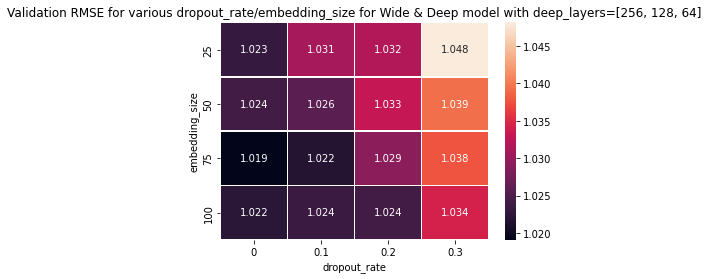

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

component = DEEP_COMPONENTS[0]
rmse_as_np = np.array([[RMSEs[(embedding_size, d_rate, ' '.join(str(x) for x in component))] for d_rate in DROPOUT_RATES] for embedding_size in EMBEDDING_SIZES])

ax_rmse = sns.heatmap(rmse_as_np, annot=True, fmt='.4g', linewidth=0.5, 
                      xticklabels=DROPOUT_RATES, yticklabels=EMBEDDING_SIZES)
ax_rmse.set_xlabel('dropout_rate', fontsize=10)
ax_rmse.set_ylabel('embedding_size', fontsize=10)
ax_rmse.set_title("Validation RMSE for various dropout_rate/embedding_size for Wide & Deep model with deep_layers={}" .format(component))
plt.show()

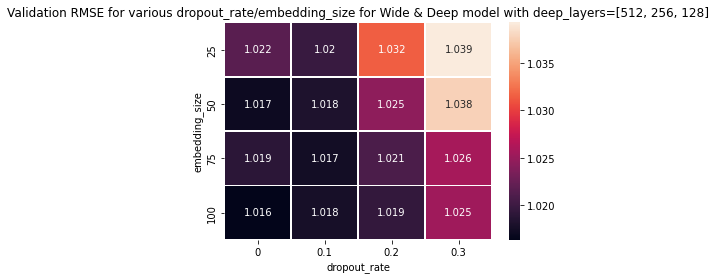

In [20]:
component = DEEP_COMPONENTS[1]
rmse_as_np = np.array([[RMSEs[(embedding_size, d_rate, ' '.join(str(x) for x in component))] for d_rate in DROPOUT_RATES] for embedding_size in EMBEDDING_SIZES])

ax_rmse = sns.heatmap(rmse_as_np, annot=True, fmt='.4g', linewidth=0.5, 
                      xticklabels=DROPOUT_RATES, yticklabels=EMBEDDING_SIZES)
ax_rmse.set_xlabel('dropout_rate', fontsize=10)
ax_rmse.set_ylabel('embedding_size', fontsize=10)
ax_rmse.set_title("Validation RMSE for various dropout_rate/embedding_size for Wide & Deep model with deep_layers={}" .format(component))
plt.show()

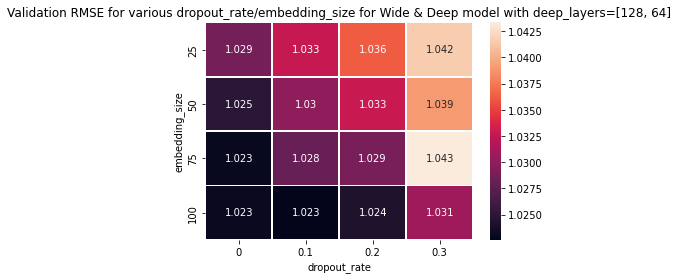

In [21]:
component = DEEP_COMPONENTS[2]
rmse_as_np = np.array([[RMSEs[(embedding_size, d_rate, ' '.join(str(x) for x in component))] for d_rate in DROPOUT_RATES] for embedding_size in EMBEDDING_SIZES])

ax_rmse = sns.heatmap(rmse_as_np, annot=True, fmt='.4g', linewidth=0.5, 
                      xticklabels=DROPOUT_RATES, yticklabels=EMBEDDING_SIZES)
ax_rmse.set_xlabel('dropout_rate', fontsize=10)
ax_rmse.set_ylabel('embedding_size', fontsize=10)
ax_rmse.set_title("Validation RMSE for various dropout_rate/embedding_size for Wide & Deep model with deep_layers={}" .format(component))
plt.show()

In [22]:
print(sorted(RMSEs, key=RMSEs.get))  # get RMSEs sorted by their RMSE

[(100, 0, '512 256 128'), (50, 0, '512 256 128'), (75, 0.1, '512 256 128'), (100, 0.1, '512 256 128'), (50, 0.1, '512 256 128'), (75, 0, '512 256 128'), (75, 0, '256 128 64'), (100, 0.2, '512 256 128'), (25, 0.1, '512 256 128'), (75, 0.2, '512 256 128'), (25, 0, '512 256 128'), (75, 0.1, '256 128 64'), (100, 0, '256 128 64'), (100, 0.1, '128 64'), (75, 0, '128 64'), (100, 0, '128 64'), (25, 0, '256 128 64'), (100, 0.1, '256 128 64'), (50, 0, '256 128 64'), (100, 0.2, '128 64'), (100, 0.2, '256 128 64'), (50, 0.2, '512 256 128'), (50, 0, '128 64'), (100, 0.3, '512 256 128'), (75, 0.3, '512 256 128'), (50, 0.1, '256 128 64'), (75, 0.1, '128 64'), (25, 0, '128 64'), (75, 0.2, '128 64'), (75, 0.2, '256 128 64'), (50, 0.1, '128 64'), (100, 0.3, '128 64'), (25, 0.1, '256 128 64'), (25, 0.2, '512 256 128'), (25, 0.2, '256 128 64'), (25, 0.1, '128 64'), (50, 0.2, '128 64'), (50, 0.2, '256 128 64'), (100, 0.3, '256 128 64'), (25, 0.2, '128 64'), (50, 0.3, '512 256 128'), (75, 0.3, '256 128 64')

In [23]:
best_config = sorted(RMSEs, key=RMSEs.get)

### Evaluate the model on train and validation sets using RMSE¶

In [25]:
# set wdl_model to be the one with lowest RMSE
deep_as_list = best_config[0][2].split()  # split with whitespace as separator
deep_as_list = [int(x) for x in deep_as_list]
wdl_model = build_wdl_model(len(tr_continuous_features[0]), 
                            item_deep_vocab_lens + user_deep_vocab_lens,
                            len(tr_wide_features[0]),
                            # new by HCJ
                            embed_size=best_config[0][0],
                            dropout_rate=best_config[0][1],
                            deep_layers=deep_as_list)
wdl_model.compile(optimizer='adagrad', loss='mse')
history = wdl_model.fit(tr_features, tr_ratings, epochs=5, verbose=1,
                        callbacks=[ModelCheckpoint('./models/model.h5')])
# make predictions and evaluate on train and validation set again
y_pred = wdl_model.predict(tr_features)
print("TRAIN RMSE: ", rmse(y_pred, tr_ratings))
y_pred = wdl_model.predict(val_features)
print("VALID RMSE: ", rmse(y_pred, val_ratings))

Epoch 1/5
1878/1878 [==============================] - 27s 14ms/step - loss: 1.9048
Epoch 2/5
1878/1878 [==============================] - 26s 14ms/step - loss: 1.0511
Epoch 3/5
1878/1878 [==============================] - 26s 14ms/step - loss: 1.0297
Epoch 4/5
1878/1878 [==============================] - 27s 14ms/step - loss: 1.0198
Epoch 5/5
1878/1878 [==============================] - 26s 14ms/step - loss: 1.0136
TRAIN RMSE:  1.0045472842304828
VALID RMSE:  1.0143703121521215


In [26]:
# added by HCJ - don't remove (prediction for test)
test_pred = wdl_model.predict(te_features)  # left join test_pred[user_id, business_id, stars] with te_df[user_id, business_id, useless]
te_df['stars'] = test_pred  # replace the te_df['stars'] dummy column
test_results = te_df.filter(['user_id', 'business_id', 'stars'])
test_results.to_csv('./test_pred.csv', index=False)

In [32]:
# added by HCJ - TODO remove
te_ratings = pd.read_csv("./test_partial.csv")
# join test_pred[user_id, business_id, stars] with te_ratings[user_id, business_id, stars] since te_ratings is incomplete
te_df_joined = pd.merge(te_df, te_ratings, on=["user_id", "business_id"], how="inner")  # should only have as many rows as te_ratings (the smaller df)
print(te_df_joined.shape)
te_pred, te_actual = te_df_joined['stars_x'].values, te_df_joined['stars_y'].values  # extract the predicted stars and actual stars
print("TEST RMSE: ", rmse(te_pred, te_actual))  # compute test RMSE

(7442, 49)
TEST RMSE:  1.0096445891731147
